# DDoS Attack Detection With ML & DL and Differential Privacy Concept

### 1.Data Preprocessing 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../source/')
from DataProcessor import DataProcessor

In [2]:
def find_common_features(my_A, my_B, my_C):
   my_s1 = set(my_A)
   my_s2 = set(my_B)
   my_s3 = set(my_C)
   my_set1 = my_s1.intersection(my_s2)
   output_set = my_set1.intersection(my_s3)
   output_list = list(output_set)
   return output_list

In [3]:
def process_basics_for_data(dataframe : pd.DataFrame) -> pd.DataFrame :
    dataProcessor: DataProcessor = DataProcessor(dataframe)
    scaledData = dataProcessor.min_max_scaler(dataframe)
    encodedScaledData = dataProcessor.label_encoder(scaledData)
    return encodedScaledData

In [4]:
mondayDataset: pd.DataFrame = pd.read_csv(
    "../verisetleri/Monday-WorkingHours.pcap_ISCX.csv", low_memory=False)
    
fridayDataSet: pd.DataFrame = pd.read_csv(
    "../verisetleri/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv", low_memory=False)
    
synDataset : pd.DataFrame = pd.read_csv("../verisetleri/01-12/Syn.csv", low_memory = False)

In [77]:
fridayDataSet

,Flow Duration,FIN Flag Count,Flow Packets/s,Fwd IAT Min,Fwd IAT Mean,Active Max,Fwd Avg Bytes/Bulk,Bwd IAT Std,Flow IAT Mean,Init_Win_bytes_forward,...,ECE Flag Count,Fwd URG Flags,Idle Min,Idle Max,Subflow Bwd Bytes,Subflow Fwd Bytes,Fwd Avg Bulk Rate,Packet Length Variance,Bwd Packet Length Mean,Fwd Header Length
0,3,0,666666.66670,3,3.0,0,0,0.0,3.0,33,...,0,0,0,0,0,12,0,0.0,0.0,40
1,109,0,18348.62385,0,0.0,0,0,0.0,109.0,29,...,0,0,0,0,6,6,0,0.0,6.0,20
2,52,0,38461.53846,0,0.0,0,0,0.0,52.0,29,...,0,0,0,0,6,6,0,0.0,6.0,20
3,34,0,58823.52941,0,0.0,0,0,0.0,34.0,31,...,0,0,0,0,6,6,0,0.0,6.0,20
4,3,0,666666.66670,3,3.0,0,0,0.0,3.0,32,...,0,0,0,0,0,12,0,0.0,0.0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225740,61,0,32786.88525,0,0.0,0,0,0.0,61.0,288,...,0,0,0,0,6,6,0,0.0,6.0,20
225741,72,0,27777.77778,0,0.0,0,0,0.0,72.0,288,...,0,0,0,0,6,6,0,0.0,6.0,20
225742,75,0,26666.66667,0,0.0,0,0,0.0,75.0,288,...,0,0,0,0,6,6,0,0.0,6.0,20
225743,48,0,41666.66667,48,48.0,0,0,0.0,48.0,4719,...,0,0,0,0,0,12,0,0.0,0.0,40


In [5]:
commonColumns = find_common_features(mondayDataset.columns, fridayDataSet.columns, synDataset.columns)
mondayDataset = mondayDataset[commonColumns]
fridayDataSet = fridayDataSet[commonColumns]
synDataset = synDataset[commonColumns]

In [6]:
processedMonday = process_basics_for_data(mondayDataset)
processedFriday = process_basics_for_data(fridayDataSet)
processedSyn = process_basics_for_data(synDataset)

In [7]:
commonColumns = find_common_features(processedMonday.columns, processedFriday.columns, processedSyn.columns)
processedMonday = processedMonday[commonColumns]
processedFriday = processedFriday[commonColumns]
processedSyn = processedSyn[commonColumns]

### 2. Feature Selection For Machine Learning

In [8]:
dataProcessor: DataProcessor = DataProcessor(processedFriday)
bestFeatureFrame = dataProcessor.chi_square_feature_selector(processedFriday)
bestFeatures = bestFeatureFrame.Specs

Output of ChiSquare Feature Selector
                      Specs         Score
3            URG Flag Count  41617.123081
53         Destination Port  39345.753421
12    Bwd Packet Length Max  32325.617363
34    Bwd Packet Length Std  22329.356165
58   Bwd Packet Length Mean  19963.264339
26     Avg Bwd Segment Size  19963.264339
19        Max Packet Length  14957.905366
48       Packet Length Mean  14596.850204
7             Bwd IAT Total  14066.375959
16        Packet Length Std  13947.536377


In [9]:
corrDataframe  = pd.concat([processedFriday[bestFeatures], processedFriday[" Label"]], axis = 1)
corrDataframe = corrDataframe.reset_index()

In [10]:
corrDataframe = corrDataframe.drop(["index"], axis=1)
corrDataframe

,URG Flag Count,Destination Port,Bwd Packet Length Max,Bwd Packet Length Std,Bwd Packet Length Mean,Avg Bwd Segment Size,Max Packet Length,Packet Length Mean,Bwd IAT Total,Packet Length Std,Label
0,0.0,0.837225,0.000000,0.0,0.000000,0.000000,0.000514,0.003098,0.0,0.0,0
1,1.0,0.840109,0.000514,0.0,0.001034,0.001034,0.000514,0.003098,0.0,0.0,0
2,1.0,0.840124,0.000514,0.0,0.001034,0.001034,0.000514,0.003098,0.0,0.0,0
3,1.0,0.705548,0.000514,0.0,0.001034,0.001034,0.000514,0.003098,0.0,0.0,0
4,0.0,0.837194,0.000000,0.0,0.000000,0.000000,0.000514,0.003098,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
225736,1.0,0.936550,0.000514,0.0,0.001034,0.001034,0.000514,0.003098,0.0,0.0,0
225737,1.0,0.936611,0.000514,0.0,0.001034,0.001034,0.000514,0.003098,0.0,0.0,0
225738,1.0,0.936565,0.000514,0.0,0.001034,0.001034,0.000514,0.003098,0.0,0.0,0
225739,0.0,0.935772,0.000000,0.0,0.000000,0.000000,0.000514,0.003098,0.0,0.0,0


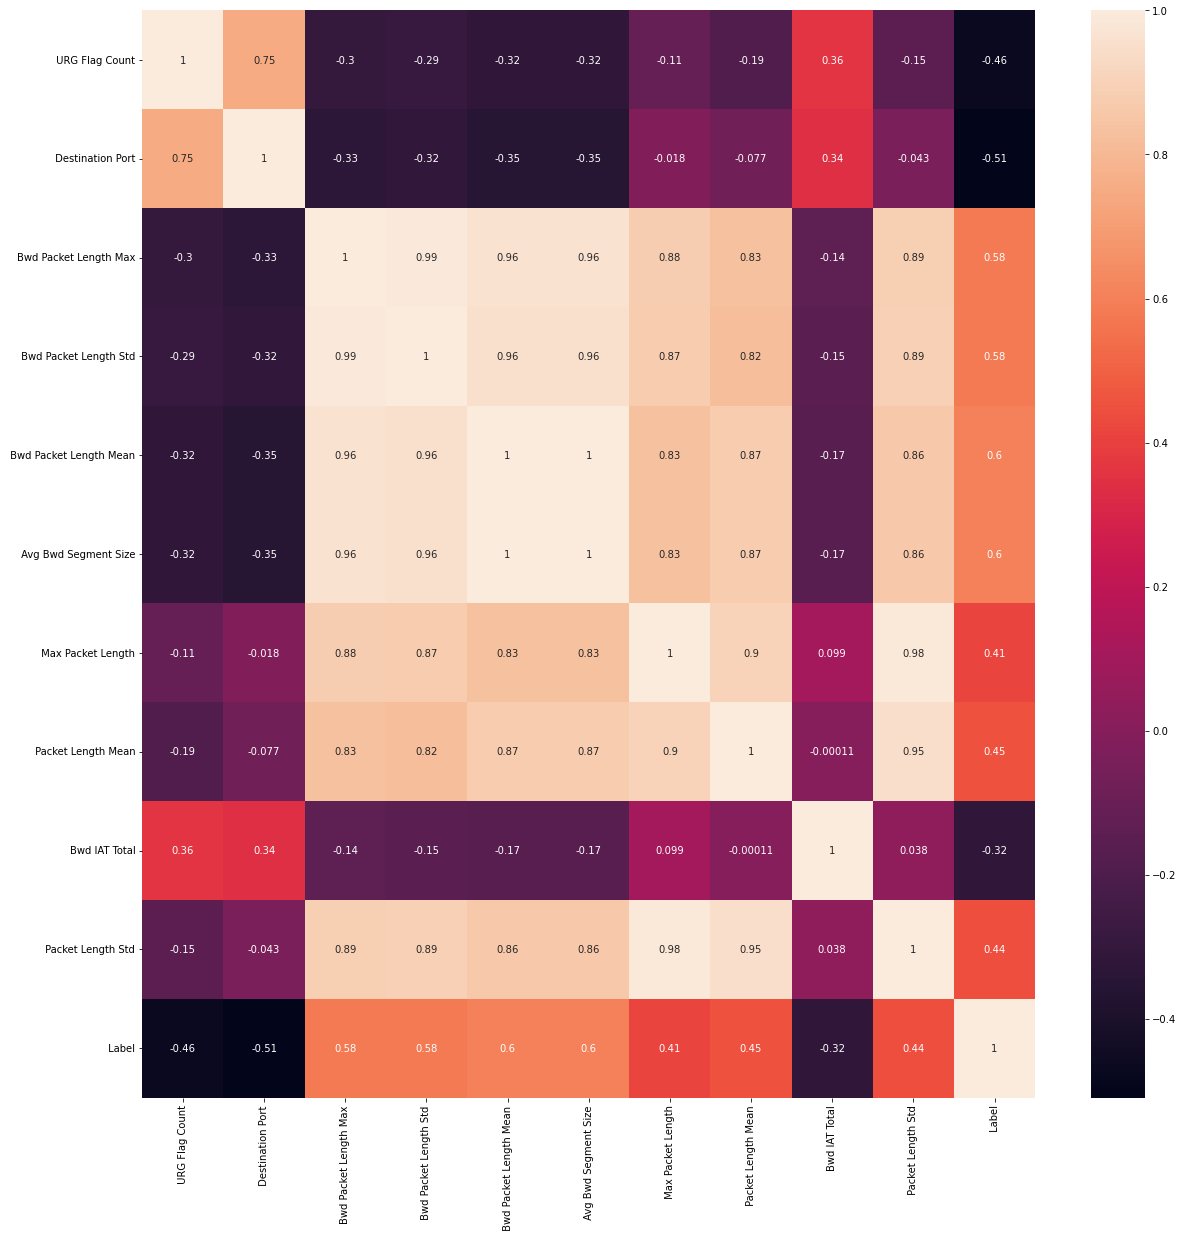

In [11]:
dataProcessor.print_correlation_matrix(corrDataframe)

## Machine Learning Methods 

In [12]:
import MLMethodBuilder as mlbuilder;
mlBuilder = mlbuilder.MLMethodBuilder(corrDataframe)

Generic Method Builder is invoke.
ML Builder is invoke


In [13]:
mlBuilder.NaiveBayes()

Data will split.
NaiveBayes Results calculated in: 0.05311989784240723 s
Confusion Matrix of Naive Bayes Classifier: 
 [[10431  9136]
 [    0 25582]]


Calculated Metrics: 

accuracy: 0.7976477884338523

precision: 1.0

recall: 0.7368512011060545

f1 score: 0.8484908789386401


In [36]:
mlBuilder.DecisionTreeClassifier(maxDepth=1)

Decision Tree Classifier Results calculated in: 0.12171578407287598 s
Confusion Matrix of Decision Tree Classifier: 
 [[11338  8229]
 [    0 25582]]


Calculated Metrics: 

accuracy: 0.817736826950763

precision: 1.0

recall: 0.7566176688060099

f1 score: 0.8614483188254508


## Using Differential Privacy 

In [75]:
mlBuilder.DifferentialNaiveBayes()

Differential NaiveBayes Results calculated in: 0.1285390853881836 s
Confusion Matrix of Naive Bayes Classifier: 
 [[18504  1063]
 [ 9330 16252]]


Calculated Metrics: 

accuracy: 0.7698066402356641

precision: 0.6352904385896333

recall: 0.9386081432284147

f1 score: 0.7577219852204117


/Users/batuhanduyuler/opt/anaconda3/envs/batuenv/lib/python3.7/site-packages/diffprivlib/models/naive_bayes.py:101: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  "privacy leakage, specify bounds for each dimension.", PrivacyLeakWarning)


In [76]:
mlBuilder.DifferentialDecisionTreeClassifier()

/Users/batuhanduyuler/opt/anaconda3/envs/batuenv/lib/python3.7/site-packages/diffprivlib/models/forest.py:371: PrivacyLeakWarning: feature_domains parameter hasn't been specified, so falling back to determining domains from the data.
This may result in additional privacy leakage. To ensure differential privacy with no additional privacy loss, specify `feature_domains` according to the documentation
  PrivacyLeakWarning)


Differential Decision Tree Classifier Results calculated in: 1.4870119094848633 s
Confusion Matrix of Differential Decision Tree Classifier: 
 [[16306  3261]
 [ 9338 16244]]


Calculated Metrics: 

accuracy: 0.720946200358812

precision: 0.6349777187084669

recall: 0.8328120994616764

f1 score: 0.7205624681171955


In [68]:
processMondayTest = processedMonday[bestFeatures][:50000]
processedSynTest = processedSyn[bestFeatures][:50000]

MondayTestLabel = np.array(processedMonday[" Label"][:50000])
SynTestLabel = np.array(processedSyn[" Label"][:50000])

In [69]:
predictionsMondayNaive = mlBuilder.predict(processMondayTest.values, "naive_bayes")
predictionsMondayDecisionTree = mlBuilder.predict(processMondayTest.values, "decision_tree")

from sklearn.metrics import accuracy_score
print('Accuracy for Monday GNB: %f' % (accuracy_score(predictionsMondayNaive, MondayTestLabel)*100))
print('Accuracy for Monday DecisionTree: %f' % (accuracy_score(predictionsMondayDecisionTree, MondayTestLabel)*100))

Accuracy for Monday GNB: 40.780000
Accuracy for Monday DecisionTree: 57.742000


In [70]:
predictionsSynNaive = mlBuilder.predict(processMondayTest.values, "naive_bayes")
predictionsSynDecisionTree = mlBuilder.predict(processedSynTest.values, "decision_tree")

from sklearn.metrics import accuracy_score
print('Accuracy for Syn GNB: %f' % (accuracy_score(predictionsSynNaive, SynTestLabel)*100))
print('Accuracy for Syn DecisionTree: %f' % (accuracy_score(predictionsSynDecisionTree, SynTestLabel)*100))

Accuracy for Syn GNB: 59.214000
Accuracy for Syn DecisionTree: 0.112000


In [39]:
text_representation = tree.export_text(mlBuilder.decisionTreeClassifier)
print(text_representation)

|--- feature_1 <= 0.00
|   |--- class: 1
|--- feature_1 >  0.00
|   |--- class: 0



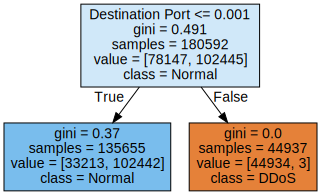

In [40]:
from sklearn import tree
import graphviz
# DOT data
dot_data = tree.export_graphviz(mlBuilder.decisionTreeClassifier, out_file=None, 
                                feature_names=processedSynTest.columns,  
                                class_names=["DDoS", "Normal"],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

In [35]:
graph.render("decision_tree_graphivz")

'decision_tree_graphivz.png'

## Convolutional Neural Networks (1D) 

In [44]:
from DLMethodBuilder import DLMethodBuilder

In [45]:
dlBuilderWithFullData = DLMethodBuilder(processedFriday)
dlBuilderWithFullData.ConvolutionalNeuralNetwork()

Generic Method Builder is invoke.
DL Builder is invoke
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 61, 64)            256       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 59, 32)            6176      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 29, 32)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 928)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 929       
Total params: 7,361
Trainable params: 7,361
Non-trainable params: 0
_________________________________________________________________


In [46]:
dlBuilderWithFullData.start_to_compile(epochNum = 5, batchSize = 256)

Data will split.
Train on 180592 samples, validate on 45149 samples
Epoch 1/5
180592/180592 [==============================] - 95s 524us/step - loss: 0.4593 - accuracy: 0.5699 - val_loss: 0.4214 - val_accuracy: 0.5666
Epoch 2/5
180592/180592 [==============================] - 93s 514us/step - loss: 0.3709 - accuracy: 0.6615 - val_loss: 0.2933 - val_accuracy: 0.9148
Epoch 3/5
180592/180592 [==============================] - 95s 525us/step - loss: 0.2023 - accuracy: 0.9483 - val_loss: 0.1260 - val_accuracy: 0.9615
Epoch 4/5
180592/180592 [==============================] - 94s 519us/step - loss: 0.0889 - accuracy: 0.9660 - val_loss: 0.0666 - val_accuracy: 0.9674
Epoch 5/5
180592/180592 [==============================] - 93s 517us/step - loss: 0.0563 - accuracy: 0.9689 - val_loss: 0.0497 - val_accuracy: 0.9688
1D CNN Results calculated in: 469.8543827533722 s


In [71]:
predictionsMonday = dlBuilderWithFullData.predict(processedMonday.drop([" Label"], axis = 1)[:50000].values)
predictionsSyn = dlBuilderWithFullData.predict(processedSyn.drop([" Label"], axis = 1)[:50000].values)

In [72]:
def labelPredictions(predictionList: np.array, dataName: str) -> list: 
    labeledPredictions = []            
    thrRatio = 1.65
    threshold = np.mean(predictionList) + thrRatio * np.std(predictionList)
    for elem in predictionList : 
        if elem > threshold:
            if (dataName == "syn"):
                labeledPredictions.append(0)
            else:
                labeledPredictions.append(1)
        else:
            if (dataName == "syn"):
                labeledPredictions.append(1)
            else:           
                labeledPredictions.append(0)
                
    return labeledPredictions

In [73]:
labeledMondayPredictions = labelPredictions(predictionsMonday, "monday")
labeledSynPredictions = labelPredictions(predictionsSyn, "syn")

In [74]:
from sklearn.metrics import accuracy_score
print('Accuracy: %f' % (accuracy_score(labeledMondayPredictions, MondayTestLabel)*100))
print('Accuracy: %f' % (accuracy_score(labeledSynPredictions, SynTestLabel)*100))

Accuracy: 86.802000
Accuracy: 89.098000
